In [1]:
# default_exp agglomerative_clustering

In [2]:
# export
from multiinstance.utils import *
from multiinstance.distanceApproaches import *
from multiinstance.data.syntheticData import buildDataset,getBag

import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KernelDensity

import scipy.stats as ss

from tqdm.notebook import tqdm



In [5]:
from numba import set_num_threads

In [6]:
# set_num_threads(20)

In [ ]:
set.union()

In [32]:
# export
class AgglomerativeClustering:
    def __init__(self, dsi, kstest_alpha,use_alphas_as_scores=True):
        self.clusterMembers = {i:[i] for i in range(dsi.N)}
        self.clusterAlphaHats = {i: dsi.alphaHats[i] for i in range(dsi.N)}
        self.clusterCurves = {i: dsi.curves[i] for i in range(dsi.N)}
        self.ds = dsi
        self.log = []
        self.deltas = []
        self.meanAbsErrs = []
        self.bagEstimateVariances = []
        self.kstest_alpha = kstest_alpha
        self.nummerges = 0
        self.use_alphas_as_scores = use_alphas_as_scores

    def clusteringIteration(self):
        # track whether any new clusters are merged, indicating this new cluster might not have
        # been compared to other clusters and a new iteration is needed to do so
        nextIterNeeded=False
        clusters = list(self.clusterMembers.keys())
        np.random.shuffle(clusters)
        for ci in tqdm(clusters, leave=False, desc="clustering iteration"):
            # might have to skip iteration if this cluster was merged elsewhere in a previous for loop iter
            if ci in self.clusterMembers.keys():
                
                # merging candidates are other remaining clusters
                candidates = list(set(self.clusterMembers.keys()) - {ci})
                np.random.shuffle(candidates)
                for cj in tqdm(candidates, leave=False, total=len(candidates),desc="candidates"):
                    if self.use_alphas_as_scores:
                        scores_i = self.clusterAlphaHats[ci]
                        scores_j = self.clusterAlphaHats[cj]
                    else:
                        # get current one-dimensional scores for all unlabeled instances in all bags in this cluster
                        scores_i = np.concatenate([getTransformScores(self.ds,
                                                                            b)[1] for b in self.clusterMembers[ci]])
                        # get scores for merge candidate cluster
                        scores_j = np.concatenate([getTransformScores(self.ds,
                                                                      b)[1] for b in self.clusterMembers[cj]])
                    # 2-sided kolmogrov-smirnov test (H0: samples from same distribution)
                    stat,p = ss.ks_2samp(scores_i.tolist(),scores_j.tolist())
                    # if you fail to reject, merge samples
                    if p > self.kstest_alpha:
                        self.nummerges += 1
                        nextIterNeeded=True
                        # add this merge to the log
                        self.log.append((ci,cj, p))
                        self.recordDelta(ci,cj)
                        # perform the actual merge
                        self.clusterMembers[ci] = self.clusterMembers[ci] + self.clusterMembers.pop(cj)
                        # track the within-bag class prior variance at each clustering iteration
                        self.doLogging()
                        
        return nextIterNeeded
        
    def recordDelta(self,ci,cj):
        # record delta est,exp
        alphaHatCI = np.mean(self.clusterAlphaHats[ci])
        ni = np.sum([self.ds.numU[b] for b in self.clusterMembers[ci]])
        alphaHatCJ = np.mean(self.clusterAlphaHats[cj])
        nj = np.sum([self.ds.numU[b] for b in self.clusterMembers[cj]])
        alphaTilde = (1 / (ni + nj)) * np.dot([ni,nj],[alphaHatCI, alphaHatCJ])
        P, _ = list(zip(*[self.ds.getBag(int(i)) for i in range(self.ds.N)]))
        _,U = list(zip(*[self.ds.getBag(b) for b in set(self.clusterMembers[ci]).union(self.clusterMembers[cj])]))
        p = np.concatenate(P)
        u = np.concatenate(U)
        alphaHats, curves = getEsts(p,u,10)
        clusterAlphaHat = np.mean(alphaHats)
        self.deltas.append(np.abs(clusterAlphaHat - alphaTilde))

    def doLogging(self):
        absErrs = []
        bagEstVar = 0
        aes = 0
        
        for bagNum,bags in self.clusterMembers.items():
            # Get cluster estimate
            if len(bags) > 1:
                P, _ = list(zip(*[self.ds.getBag(int(i)) for i in range(self.ds.N)]))
                _,U = list(zip(*[self.ds.getBag(b) for b in bags]))
                p = np.concatenate(P)
                u = np.concatenate(U)
                alphaHats, curves = getEsts(p,u,10)
                clusterAlphaHat = np.mean(alphaHats)
                self.clusterAlphaHats[bagNum] = alphaHats
                self.clusterCurves[bagNum] = curves
                clusterAlphas = self.ds.trueAlphas[bags].flatten()
            else:
                clusterAlphaHat = self.ds.alphaHats[bags].mean(1)
                clusterAlphas = self.ds.trueAlphas[bags].flatten()
            absErrs.append(np.abs(clusterAlphaHat - clusterAlphas))
            # Get the true and predicted alphas for each bag in this cluster
            bagsAlphaHat = self.ds.alphaHats[bags].reshape((len(bags),-1)).mean(1)
            # log abs. err for this cluster
            # add to calculation for variance in estimates for this cluster
            bagEstVar += np.sum((bagsAlphaHat - clusterAlphaHat)**2)

            
        self.meanAbsErrs.append(np.mean(np.concatenate(absErrs)))
        self.bagEstimateVariances.append(bagEstVar / (self.ds.N - 1))

    def cluster(self):
        self.doLogging()
        nextIterNeeded = self.clusteringIteration()
        while nextIterNeeded:
            nextIterNeeded = self.clusteringIteration()
                                       

In [56]:
def deltasPlot(ax,agg):
    x = np.arange(len(agg.deltas))
    y = agg.deltas
    # calc the trendline
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    ax.scatter(np.arange(len(agg.deltas)), agg.deltas)
    ax.plot(x,p(x),"r--")

In [71]:
def makeCurvePlots(agg):
    for i,bags in agg.clusterMembers.items():
        j = np.random.randint(0,high=10)
        c = agg.clusterCurves[i][j]
        # plot a curve for this cluster
        plt.plot(np.arange(0,1,.01),(c - c.min()) / (c.max() - c.min()))
        # plot the estimates for this curve
        plt.vlines(agg.clusterAlphaHats[i][j],0,1,color="red",label=r"$\hat{\alpha}$")
        # plot true alphas for each bag
        nPs = np.array([agg.ds.numP[b] for b in bags])
        nUs = np.array([agg.ds.numU[b] for b in bags])
        plt.vlines([agg.ds.trueAlphas[b] for b in bags],
                   np.zeros(len(bags)), nPs/nPs.sum(), color="black", label=r"$\alpha$")
        plt.title("num bags: {}    numP: {}    numU: {}".format(len(bags),
                                                            nPs.sum(),
                                                            nUs.sum()))
        plt.legend(loc="upper right")
        plt.show()


In [74]:
addTransformScores??

In [65]:
dsi = buildDataset(250,alphaDistr=lambda: np.random.uniform(.01,.5))

dsi = addTransformScores(dsi)

dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,numbootstraps=10)



In [66]:
agg0 = AgglomerativeClustering(dsi, .5,use_alphas_as_scores=False)
agg0.cluster()


Text(0.5, 0, 'number of cluster merges')

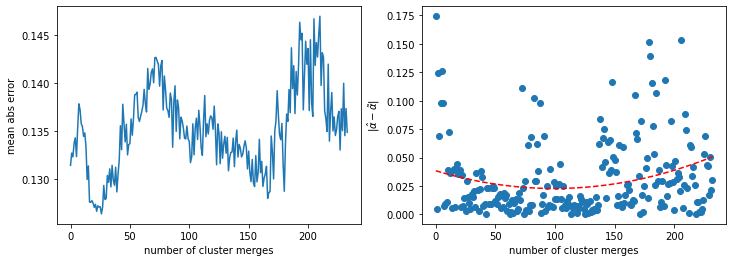

In [67]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

axs[0].plot(agg0.meanAbsErrs)

deltasPlot(axs[1],agg0)
axs[0].set_ylabel("mean abs error")
axs[0].set_xlabel("number of cluster merges")

axs[1].set_ylabel(r"$|\hat{\alpha} - \tilde{\alpha}|$")
axs[1].set_xlabel("number of cluster merges")

In [68]:
agg1 = AgglomerativeClustering(dsi, .5,use_alphas_as_scores=True)
agg1.cluster()

Text(0.5, 0, 'number of cluster merges')

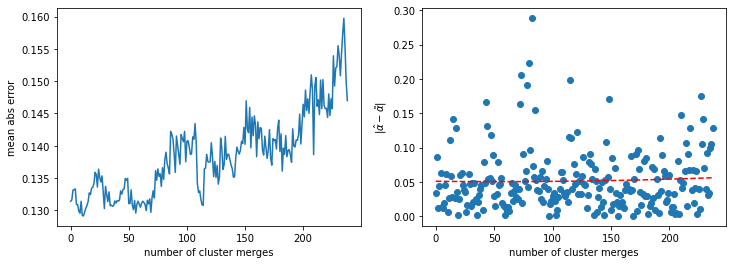

In [69]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

axs[0].plot(agg1.meanAbsErrs)

deltasPlot(axs[1],agg1)
axs[0].set_ylabel("mean abs error")
axs[0].set_xlabel("number of cluster merges")

axs[1].set_ylabel(r"$|\hat{\alpha} - \tilde{\alpha}|$")
axs[1].set_xlabel("number of cluster merges")

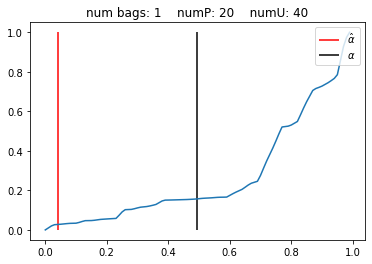

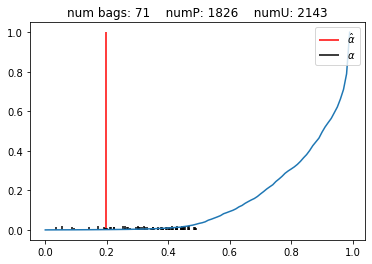

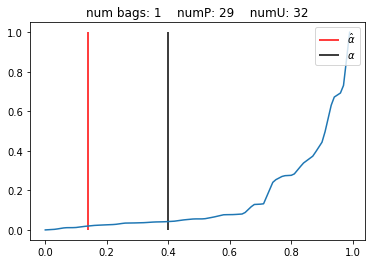

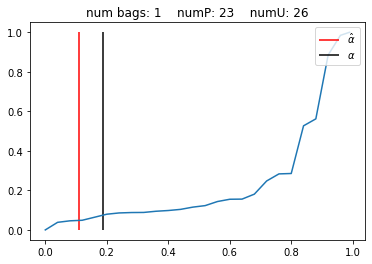

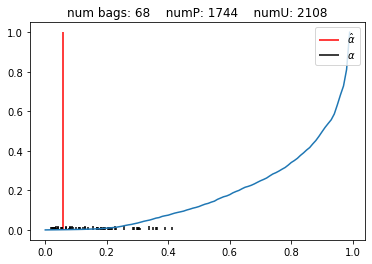

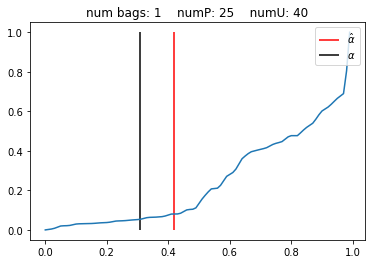

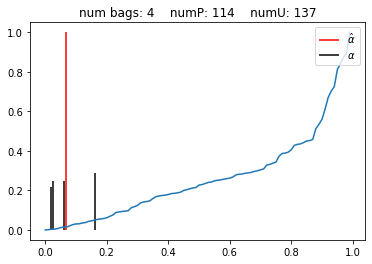

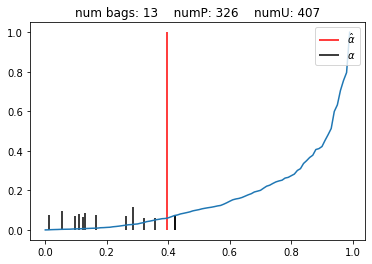

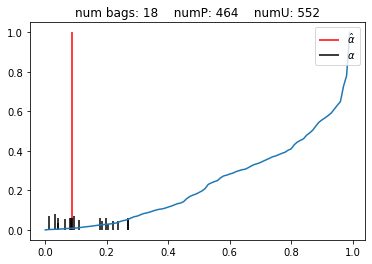

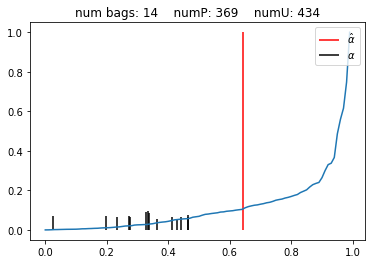

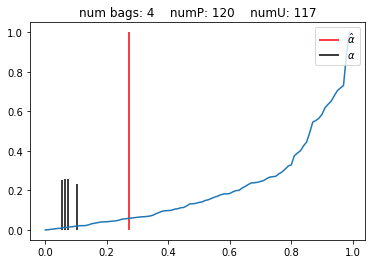

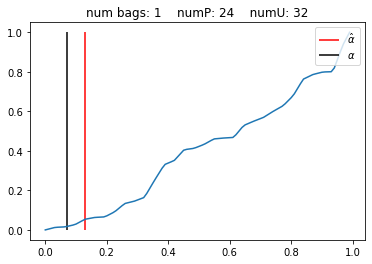

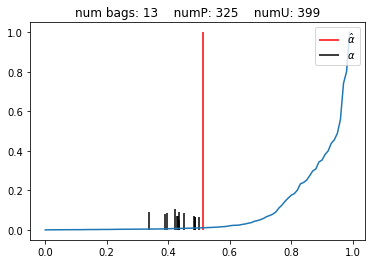

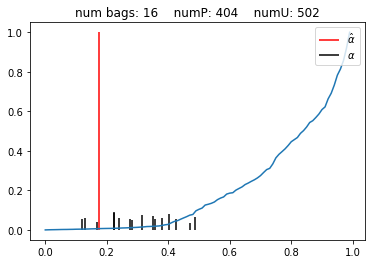

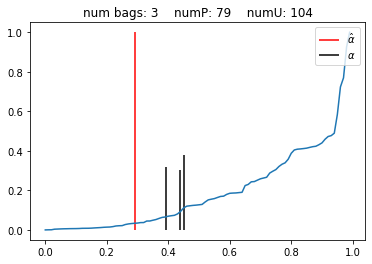

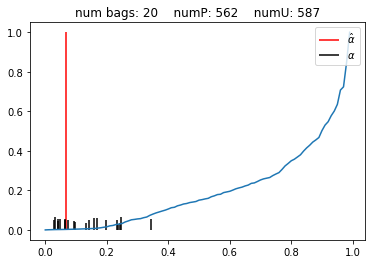

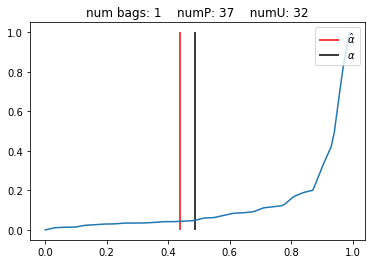

In [72]:
makeCurvePlots(agg0)

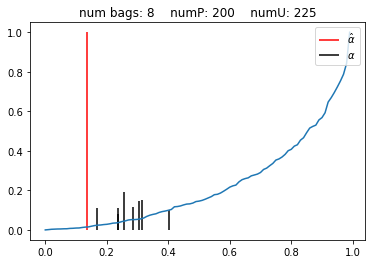

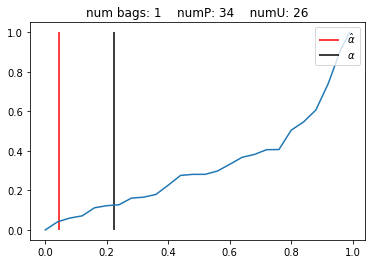

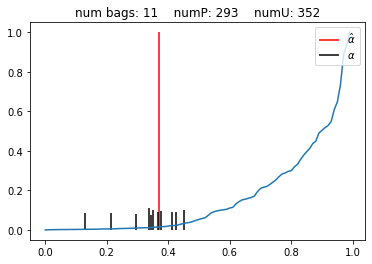

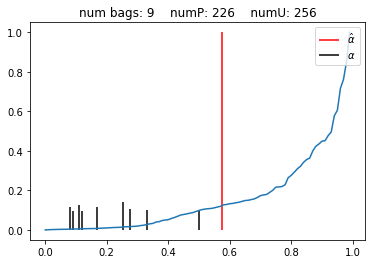

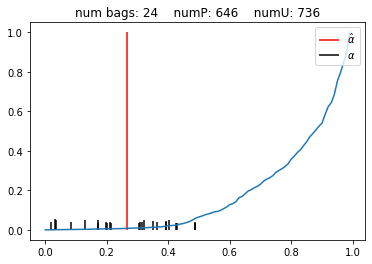

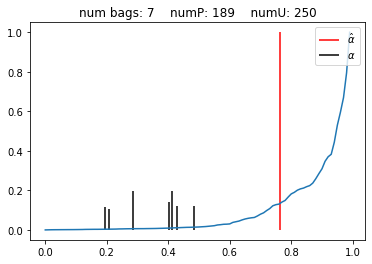

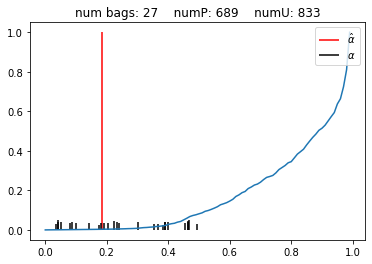

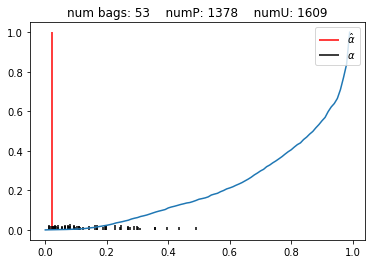

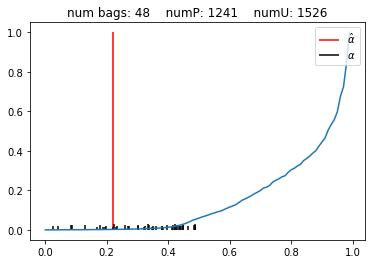

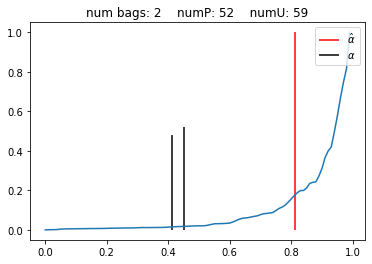

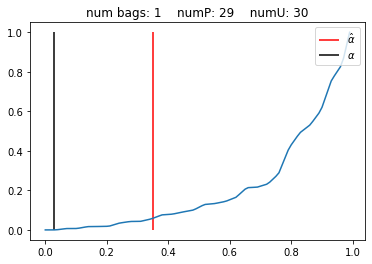

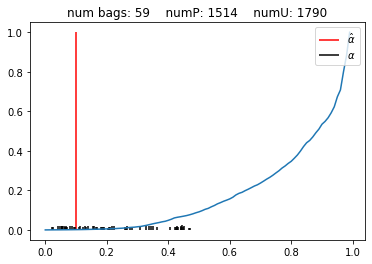

In [73]:
makeCurvePlots(agg1)

It appears that using the alpha hats in the KS-test leads to tighter clusters wrt. bag class priors